In [30]:
import torch
import gpytorch

# Define the data
train_x = torch.linspace(-2, 2, 100)
train_y = torch.sin(train_x/2 * 3.1416)
# Define the Gaussian process model
class GPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.RBFKernel() 
        self.covar_module = gpytorch.kernels.MaternKernel(nu=1.5)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# Create the model and likelihood
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = GPModel(train_x, train_y, likelihood)

# Train the model
model.train()
likelihood.train()

# Set optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

# Training loop
for _ in range(100):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    optimizer.step()

# Set the model to evaluation mode
model.eval()
likelihood.eval()

# Compute the mean and variance
test_x = torch.tensor([0.5], requires_grad=True)  # New input for computing derivatives

#with torch.no_grad(), gpytorch.settings.fast_pred_var():
output = model(test_x)
mean = output.mean
variance = output.variance

# Compute the derivatives of the mean and variance
mean.backward(retain_graph=True)
mean_derivative = test_x.grad.clone()
test_x.grad.zero_()  # Clear the gradient for the next computation

variance.backward(retain_graph=True)
variance_derivative = test_x.grad.clone()

In [31]:
import matplotlib.pyplot as plt
# Compute the derivatives of the mean and variance
test_x=train_x = torch.linspace(-10, 20, 1000)
test_x.requires_grad_(True)
mean_value = model(test_x).mean
variance_value = model(test_x).variance
mean_derivative = torch.autograd.grad(mean_value, test_x, grad_outputs=torch.ones_like(mean_value))[0]
variance_derivative = torch.autograd.grad(variance_value, test_x, grad_outputs=torch.ones_like(variance_value))[0]

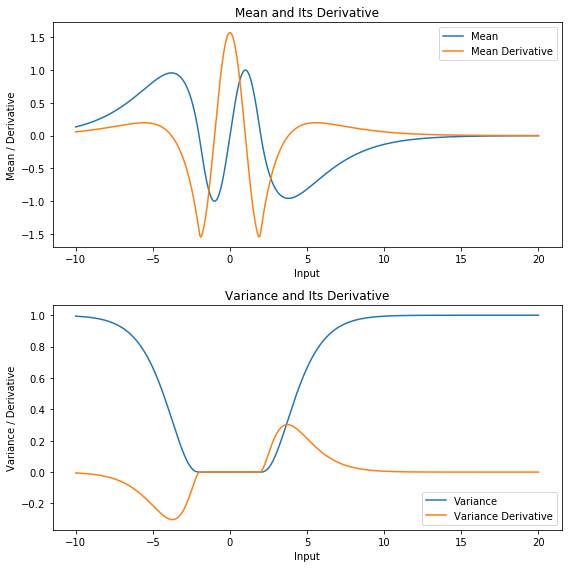

In [32]:
# Plot the results
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8))

with torch.no_grad():
    # Plot the mean and its derivative
    ax1.plot(test_x.numpy(), mean_value.numpy(), label='Mean')
    ax1.plot(test_x.numpy(), mean_derivative.numpy(), label='Mean Derivative')
    ax1.set_xlabel('Input')
    ax1.set_ylabel('Mean / Derivative')
    ax1.set_title('Mean and Its Derivative')
    ax1.legend()

    # Plot the variance and its derivative
    ax2.plot(test_x.numpy(), variance_value.numpy(), label='Variance')
    ax2.plot(test_x.numpy(), variance_derivative.numpy(), label='Variance Derivative')
    ax2.set_xlabel('Input')
    ax2.set_ylabel('Variance / Derivative')
    ax2.set_title('Variance and Its Derivative')
    ax2.legend()

    plt.tight_layout()
    plt.show()